## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
#read the data
df = pd.read_csv('ab_data.csv')

#show the first 5 rows
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
#Show the number of rows
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
#show the number of unique users in df
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
#Show the values in group column
df.group.value_counts()

treatment    147276
control      147202
Name: group, dtype: int64

In [7]:
#Show the values in landing_page column
df.landing_page.value_counts()

old_page    147239
new_page    147239
Name: landing_page, dtype: int64

In [8]:
#the number of times the new_page and treatment don't match
n_times=df.query('group == "control" and landing_page == "new_page" or group == "treatment" and landing_page == "old_page"').count()
n_times[0]

3893

f. Do any of the rows have missing values?

In [9]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
# create df2 where we excluded the rows where treatment does not match with new_page or control does not match with old_page.
df2 = df[((df['group']=='treatment') & (df['landing_page']=='new_page')) | ((df['group']=='control') & (df['landing_page']=='old_page'))]

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [14]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
#shape before removing duplicates
df2.shape

(290585, 5)

In [16]:
#drop the duplicates
df2= df2.drop_duplicates(subset='user_id')

In [17]:
#shape after removing duplicates
df2.shape

(290584, 5)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [18]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
df2.query('group =="control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
df2.query('group =="treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [21]:
(df2['landing_page'] == 'new_page').mean()

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

- **The calculations of probability above shows that the `control` group converted is higher than the `treatment` group converted and The probability that an individual received the new page is 0.500**

- **The results above do not provide sufficient evidence to conclude that the new treatment page leads to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

- $$ H_0: p_{new}  <= p_{old}$$
- $$ H_1: p_{new}  >  p_{old}$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [22]:
P_new = df2['converted'].mean()
P_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [23]:
P_old = df2['converted'].mean()
P_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [24]:
N_new =  df2.query('landing_page == "new_page"').shape[0]
N_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [25]:
N_old =  df2.query('landing_page == "old_page"').shape[0]
N_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
new_page_converted = np.random.choice([1, 0], size=N_new, p=[P_new, (1-P_new)]).mean()
new_page_converted

0.1187598926433143

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
old_page_converted = np.random.choice([1, 0], size=N_old, p=[P_old, (1-P_old)]).mean()
old_page_converted

0.11934000578217713

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
diff=new_page_converted - old_page_converted 
diff

-0.00058011313886283111

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [29]:
p_diffs = []

for i in range(10000):
    new_page_converted = np.random.choice([1, 0], size=N_new, p=[P_new, (1-P_new)]).mean()
    old_page_converted = np.random.choice([1, 0], size=N_old, p=[P_old, (1-P_old)]).mean()
    diff = new_page_converted - old_page_converted 
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

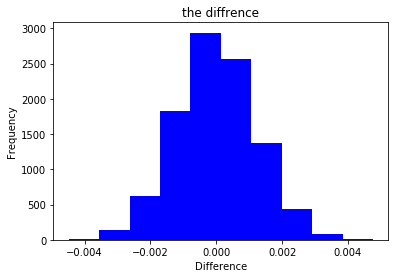

In [30]:
plt.hist(p_diffs, color = "blue")
plt.title("the diffrence")
plt.xlabel('Difference')
plt.ylabel('Frequency');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
#the actual difference observed in ab_data.csv
act_diff=df2[df2['group'] == 'treatment']['converted'].mean()-df2[df2['group'] == 'control']['converted'].mean()

In [32]:
#the proportion (p-value)
(p_diffs > act_diff).mean()

0.9073

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

- **It is called P-value that observing if the Null is true.**

- **The old pages is better than the new pages means thst it fails to reject the Null because P-value is large.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm

convert_old = sum(df2.query("group == 'control'")['converted'])
convert_new = sum(df2.query("group == 'treatment'")['converted'])
n_old = N_old
n_new = N_new

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [34]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

In [35]:
# Shows z_score significance.. 
norm.cdf(z_score)

0.094941687240975514

In [36]:
# for Type I error rate of 5%, as be shown in part II.1..

norm.ppf(1-0.05)

1.6448536269514722

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

- **z_score is less than 1.6448, though it fails to reject the Null; and it agrees with the results in parts j & k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
df2['intercept'] = 1
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['group'])

In [38]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [39]:
logit = sm.Logit(df2['converted'], df2[['ab_page', 'intercept']])
results = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [40]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-11-20 20:45 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
ab_page       0.0150    0.0114     1.3109  0.1899  -0.0074   0.0374
intercept    -2.0038    0.0081  -247.1457  0.0000  -2.0197  -1.9879
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

- **P-value = 0.1899 and We get different P-value than the one in partII,because in PartII was randomly choosed(10000) and we use one side test in it.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

- **Adding other factors to the model is better because it will increase the accuracy .**

- **Yes, there are disadvantages of adding new terms that can actually make the model worse by overfit your model.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

- **From the results, we found that country had no signifcant impact on conversion.**

In [41]:
#df_C that countain the data from 'countries.csv'..
df_C = pd.read_csv('countries.csv')

#show the first 5 rows
df_C.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [42]:
#show the shape of df_C
df_C.shape

(290584, 2)

In [43]:
#show first 5 rows of df2
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


In [44]:
#show the shape of df2
df2.shape

(290584, 8)

In [45]:
#Merge df2 with df_C by their user_id
df_merged = df2.set_index('user_id').join(df_C.set_index('user_id'))

#show first 5 rows of df_merged
df_merged.head()

,timestamp,group,landing_page,converted,intercept,ab_page,old_page,country
user_id,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US


In [46]:
#to show the number of values in country column
df_merged['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [47]:
#create the dummy variables..
df_merged[['CA', 'US', 'UK']] = pd.get_dummies(df_merged['country'])

In [48]:
#show the first 5 rows
df_merged.head()

,timestamp,group,landing_page,converted,intercept,ab_page,old_page,country,CA,US,UK
user_id,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [49]:
log_ = sm.Logit(df_merged['converted'], df_merged[['intercept','CA', 'US']])
result = log_.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-11-20 20:45 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
US            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

- **The P-values for hte countries are higer than 0.05. And so we will look at an interaction between page and country to see if there significant effects on conversion.**

In [50]:
#add interaction between page and country columns
df_merged['CA_page'] = df_merged['CA'] * df_merged['ab_page']
df_merged['US_page'] = df_merged['US'] * df_merged['ab_page']
df_merged.head()

,timestamp,group,landing_page,converted,intercept,ab_page,old_page,country,CA,US,UK,CA_page,US_page
user_id,,,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1,0,0
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1,0,0
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1,0,0
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1,0,0
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1,0,0


In [53]:
log_ = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'CA', 'US', 'CA_page', 'US_page']])
result = log_.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-11-20 20:49 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -2.0070    0.0097  -207.0454  0.0000  -2.0260  -1.9880
ab_page       0.0206    0.0137     1.5052  0.1323  -0.0062   0.0473
CA           -0.0644    0.0384    -1.6788  0.0932  -0.1396   0.0108
US            0.0257    0.0188     1.3634  0.1728  -0.0112   0.0625
CA_page       0.0469    0.0538     0.8718  0.3833  -0.0585   0.1523
US_page      -0.0314    0.0266    -1.1807  0.2377  -0.0835   0.0207
==================================================================

"""

- **P-values still  higer than 0.05. Therefore, we fail to reject the null and the evidence that there is no an interaction between country and page.**

# Conclusions

- **Finally from all the above we found that we do not have sufficient evidence to say that the new page is better than the old page.**

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [54]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0